In [5]:
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from ast import literal_eval
import json

In [6]:
file_name = "9M-5-[1-2001]-[a]-lcm.out"
output_file = f"queries_results/python_{file_name.replace('out','csv')}"

In [9]:
encoder = LabelEncoder()
encoder.classes_ = np.load(f'../../plots/encoders/{file_name}.npy')

def splited_links():
    links = pd.read_csv(f"../../plots/links/{file_name}")
    res = []
    links.apply(lambda x : [res.append((x["source"],x["target"], int(i) )) for i in x["user_id"].split(",")] ,axis=1)
    return  pd.DataFrame(res,columns=["source","target","user_id"])
def partial_df():
    # Groupes over two periods only
    links = splited_links()
    groups = pd.read_csv(f"../../plots/groups/{file_name}",index_col=0)
    groups.drop(["itemset_name","property_values"],axis=1,inplace=True)
    groups = groups.drop(['depth',"a","size","support",],axis=1)
    groups["itemsets"] = groups["itemsets"].apply(lambda x :set(encoder.inverse_transform([int(i) for i in x.split()])))
    groups["user_ids"] =  groups["user_ids"].apply(literal_eval)
    links = links.merge(groups.reset_index(),left_on="source",right_on='index').merge(groups.reset_index(),left_on="target",right_on='index')
    links.drop(["source","target","index_x","index_y","user_ids_x","user_ids_y"],axis=1,inplace=True)
    return links
def full_df():
    # Groups over three periods only
    links = splited_links()
    links = links.merge(links,left_on=["target","user_id"],right_on=["source","user_id"]).drop(["source_y"],axis=1)
    
    groups = pd.read_csv(f"../../plots/groups/{file_name}",index_col=0)
    groups.drop(["itemset_name","property_values","user_ids"],axis=1,inplace=True)
    groups = groups.drop(['depth',"a","size","support",],axis=1)
    groups["itemsets"] = groups["itemsets"].apply(lambda x :set(encoder.inverse_transform([int(i) for i in x.split()])))
    
    links = links.merge(groups,left_on="source_x",right_index=True).merge(groups,left_on="target_x",right_index=True).merge(groups,left_on="target_y",right_index=True)
    links = links.rename(columns={"itemsets":"itemsets_z","period":"period_z"})
    links.drop(["source_x","target_x","target_y"],axis=1,inplace=True)
    return links

with open("../../datasets/Total/ids_mapping.json","r") as file:
    mapping = json.load(file)
def extract_user_stats(x,columns):
    user = x["user_id"]
    for col in columns:
        for val in x[col]:
            res.append((user,col,val))

## Queries

In [10]:
df=full_df()
df.head()

,user_id,itemsets_x,period_x,itemsets_y,period_y,itemsets_z,period_z
0,129151,{3428271930050},2018-09-01,{3439495300031},2018-12-01,"{3428271930050, 3221320080719}",2019-02-01
1,129151,{3428271930050},2018-09-01,{3439495300031},2018-12-01,{3221320080719},2019-02-01
2174,549038,{3438351358933},2018-09-01,{3438351358933},2018-12-01,{3221320080719},2019-02-01
3987,267956,{3438351358933},2018-09-01,{3438351358933},2018-12-01,{3221320080719},2019-02-01
2146,549038,"{7612720201624, 3438351358933}",2018-09-01,{3438351358933},2018-12-01,{3221320080719},2019-02-01


In [11]:
df["adoption"] = df.apply(lambda x: x["itemsets_y"].difference(x["itemsets_x"]),axis=1)
df["loyalty1"] = df.apply(lambda x: x["itemsets_y"].intersection(x["itemsets_x"]),axis=1)
df["loyalty2"] = df.apply(lambda x: x["itemsets_y"].intersection(x["itemsets_z"]),axis=1)

df["promo_exclusive_products"] = df.apply(lambda x : x["itemsets_y"].difference(x["itemsets_x"]).difference(x["itemsets_z"]),axis=1)
df["replacement"] = df.apply(lambda x : x["itemsets_x"].intersection(x["itemsets_y"]).difference(x["itemsets_z"]),axis=1)
df["loyalty"] = df.apply(lambda x :x["itemsets_x"].intersection(x["itemsets_y"].intersection(x["itemsets_z"])),axis=1)

# Stats

In [12]:
users= pd.read_csv("../../datasets/Total/users.csv",sep=";")
items = pd.read_csv("../../datasets/Total/items.csv",index_col=0).drop("IDS_LIST",axis=1)
res = []
queries_columns = df.columns.tolist()[7:]
df.apply(lambda x : extract_user_stats(x,queries_columns),axis=1)
stats_df = pd.DataFrame(res,columns=["CUST_ID","query_type","ARTICLE_ID"])
stats_df = stats_df.merge(users).merge(items)
stats_df.head(10)
# stats_df.to_csv("stats.csv")

,CUST_ID,query_type,ARTICLE_ID,SEX,AGE,DEPARTEMENT,DESCRIPTION
0,129151,adoption,3439495300031,M,35-49,62,PASTIS AZUR 50CL
1,129151,promo_exclusive_products,3439495300031,M,35-49,62,PASTIS AZUR 50CL
2,129151,adoption,3439495300031,M,35-49,62,PASTIS AZUR 50CL
3,129151,promo_exclusive_products,3439495300031,M,35-49,62,PASTIS AZUR 50CL
4,129151,adoption,3439495300031,M,35-49,62,PASTIS AZUR 50CL
5,129151,promo_exclusive_products,3439495300031,M,35-49,62,PASTIS AZUR 50CL
6,131514,adoption,3439495300031,M,50-65,78,PASTIS AZUR 50CL
7,131514,promo_exclusive_products,3439495300031,M,50-65,78,PASTIS AZUR 50CL
8,131514,adoption,3439495300031,M,50-65,78,PASTIS AZUR 50CL
9,131514,promo_exclusive_products,3439495300031,M,50-65,78,PASTIS AZUR 50CL


In [14]:
stats_df.query_type.value_counts()

adoption                    2930
promo_exclusive_products    2119
loyalty2                    1527
loyalty1                    1441
replacement                  725
loyalty                      716
Name: query_type, dtype: int64

### By users

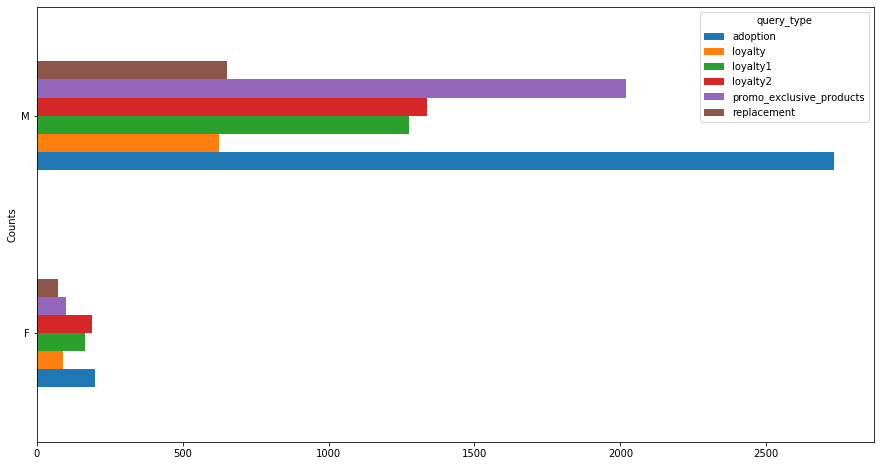

In [13]:
ax = stats_df.groupby(["SEX"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

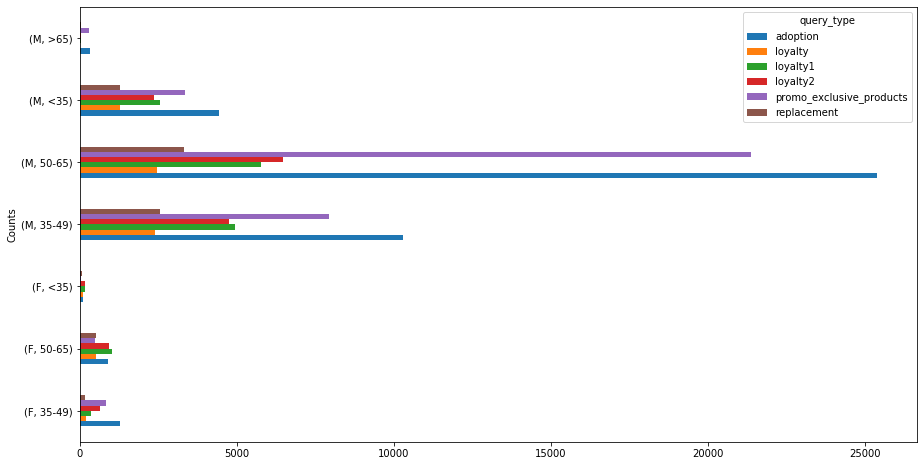

In [14]:
ax = stats_df.groupby(["SEX","AGE"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

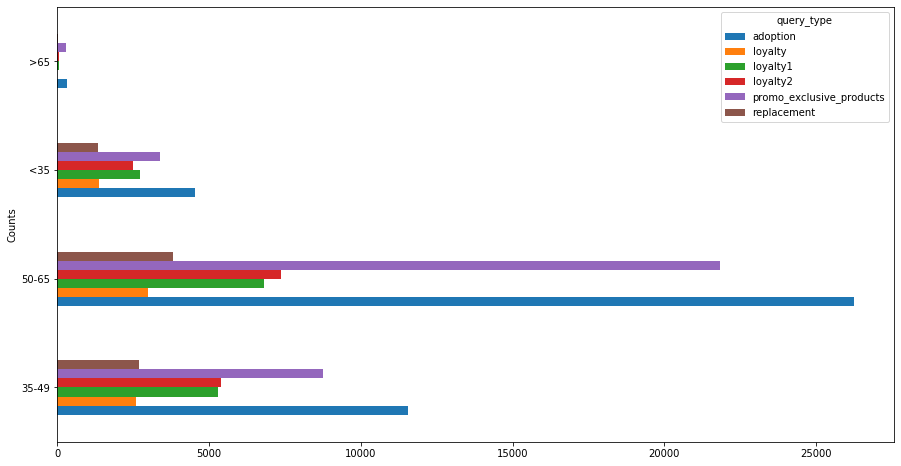

In [15]:
ax = stats_df.groupby(["AGE"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

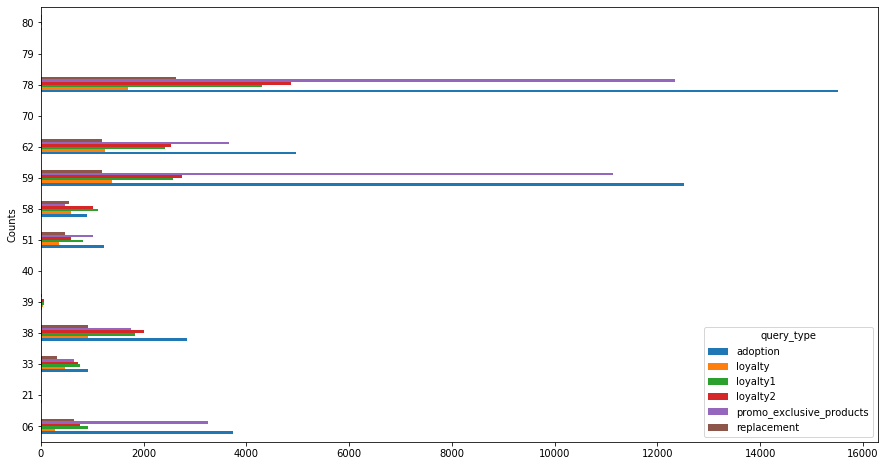

In [16]:
ax = stats_df.groupby(["DEPARTEMENT"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

### By items

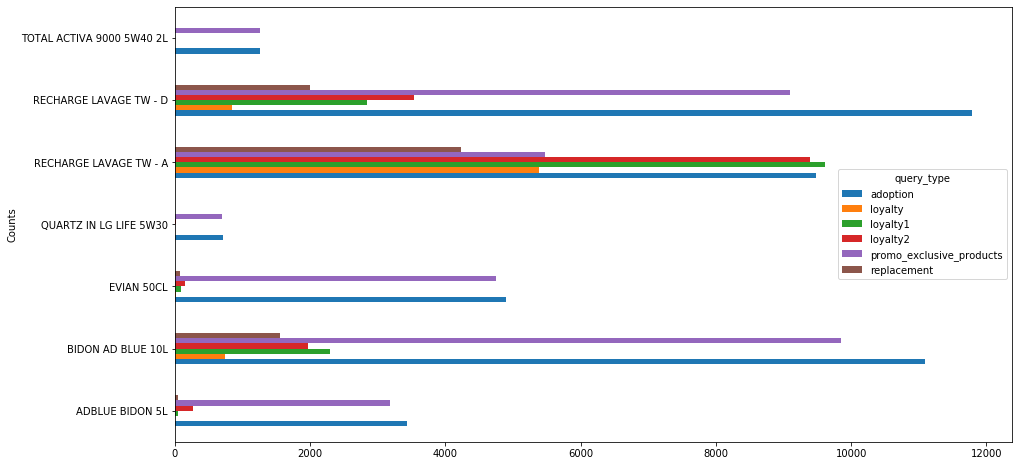

In [17]:
ax = stats_df.groupby(["DESCRIPTION"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")